In [196]:
%load_ext autoreload
%autoreload 2
import numpy as np
from skimage.io import imread
import torch
import matplotlib.pyplot as plt
import pandas as pd
from br.features.utils import normalize_intensities_and_get_colormap_apply
from skimage import measure
from pathlib import Path
from pyntcloud import PyntCloud
import os
from br.data.preprocessing.pc_preprocessing.pcna import compute_labels

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [187]:
# utility plot functions
def plot_image(ax_array, struct, nuc, mem, vmin, vmax, num_slices=None):
    mid_z = int(struct.shape[0]/2)
    
    if num_slices is None:
        num_slices = mid_z*2
    z_interp = np.linspace(mid_z-num_slices/2, mid_z+num_slices/2, num_slices+1).astype(int)
    if z_interp.max() == struct.shape[0]:
        z_interp = z_interp[:-1]

    mem = mem[z_interp].max(0)
    nuc = nuc[z_interp].max(0)
    mem_contours = measure.find_contours(mem, 0.5)
    nuc_contours = measure.find_contours(nuc, 0.5)

    for ind, _ in enumerate(ax_array):
        this_struct = struct
        if ind > 0:
            this_struct = np.zeros(struct.shape)
        ax_array[ind].imshow(this_struct[z_interp].max(0), cmap='gray_r', vmin=vmin, vmax=vmax)
        for contour in nuc_contours:
            ax_array[ind].plot(contour[:, 1], contour[:, 0], linewidth=2, c='cyan')
        for contour in mem_contours:
            ax_array[ind].plot(contour[:, 1], contour[:, 0], linewidth=2, c='magenta')
        ax_array[ind].axis("off")
    return ax_array, z_interp


def plot_pointcloud(this_ax_array, points_all, z_interp, cmap, save_path=None, name=None, center=None, save=False):
    this_p = points_all.loc[points_all['z'] < max(z_interp)]
    this_p = this_p.loc[this_p['z'] > min(z_interp)]
    print(this_p.shape)
    intensity = this_p.inorm.values
    this_ax_array.scatter(this_p['x'].values, this_p['y'].values, c=cmap(intensity), s=0.3, alpha=0.5)
    this_ax_array.axis("off")
    if save:
        z_center, y_center, x_center = center[0], center[1], center[2]

        # Center and scale for viz
        this_p["z"] = this_p["z"] - z_center
        this_p["y"] = this_p["y"] - y_center
        this_p["x"] = this_p["x"] - x_center

        this_p['z'] = 0.1 * this_p['z']
        this_p['x'] = 0.1 * this_p['x']
        this_p['y'] = 0.1 * this_p['y']
        Path(save_path).mkdir(parents=True, exist_ok=True)
        colors = cmap(this_p['inorm'].values)[:,:3]
        np_arr = this_p[['x', 'y', 'z']].values
        np_arr2 = colors
        np_arr = np.concatenate([np_arr, np_arr2], axis=1)
        np.save(Path(save_path) / Path(f'{name}.npy'), np_arr) 


In [146]:
# Set paths
os.chdir("/allen/aics/modeling/ritvik/projects/benchmarking_representations/")
save_path = './viz_pcna_pointclouds/'

In [3]:
orig_image_df = pd.read_parquet('/allen/aics/modeling/ritvik/pcna/manifest.parquet')
df_all = pd.read_csv("/allen/aics/assay-dev/computational/data/4DN_handoff_Apr2022_testing/PCNA_manifest_for_suraj_with_brightfield.csv")
orig_image_df = orig_image_df.merge(df_all[['CellId', 'crop_raw', 'crop_seg']], on='CellId')

In [183]:
# Sample CellId
strat = 'cell_stage_fine'
strat_val = 'midS'
this_image = orig_image_df.loc[orig_image_df[strat] == strat_val].sample(n=1)
cell_id = this_image['CellId'].iloc[0]

In [224]:
# Sample dense point cloud and get images
points_all, struct, img, center = compute_labels(this_image.iloc[0], False)
img_raw = img[2]
img_nuc = img[6]
img_mem = img[7]
img_raw = np.where(img_raw < 60000, img_raw, img_raw.min())

# from saved PC
# points_all = PyntCloud.from_file(this_image['pcloud_path_updated_morepoints'].iloc[0]).points
# z_center, y_center, x_center = center[0], center[1], center[2]
# # Center and scale for viz
# points_all["z"] = points_all["z"] + z_center
# points_all["y"] = points_all["y"] + y_center
# points_all["x"] = points_all["x"] + x_center


In [226]:
# Sample sparse point cloud and get images

probs2 = points_all["s"].values
probs2 = np.where(probs2 < 0, 0, probs2)
probs2 = probs2 / probs2.sum()
idxs2 = np.random.choice(
    np.arange(len(probs2)), size=2048, replace=True, p=probs2
)
points = points_all.iloc[idxs2].reset_index(drop=True)

In [227]:
points_all

,z,y,x,s
0,35.000128,154.999986,115.000072,1201
1,50.000308,119.000383,182.999816,1164
2,51.000293,118.999646,183.000379,1209
3,52.999609,118.999713,182.999630,1135
4,51.999926,119.000266,182.999591,1183
...,...,...,...,...
20475,34.000402,127.999693,156.999943,603
20476,33.000070,180.000294,106.999907,640
20477,52.000452,173.999879,171.999956,589
20478,40.999974,173.999961,117.999851,604


In [228]:
# Apply contrast to point clouds
vmin = 503
vmax = 1000
points = normalize_intensities_and_get_colormap_apply(points, vmin, vmax)
points_all = normalize_intensities_and_get_colormap_apply(points_all, vmin, vmax)
cmap = plt.get_cmap('Purples')

(9701, 5)
(1000, 5)


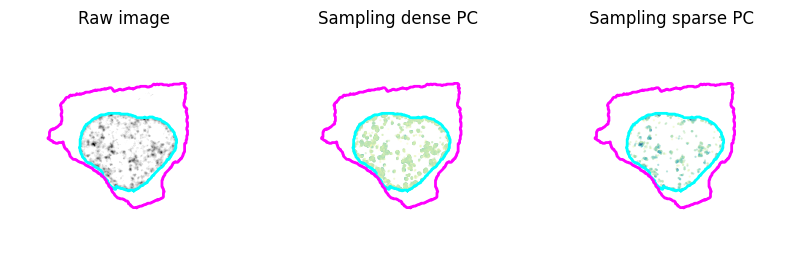

In [231]:
%matplotlib inline

save=False
fig, ax_array = plt.subplots(1,3, figsize=(10, 5))

ax_array, z_interp = plot_image(ax_array, img_raw, img_nuc, img_mem, vmin, vmax, num_slices=20)
ax_array[0].set_title('Raw image')

plot_pointcloud(ax_array[1], points_all, z_interp, plt.get_cmap('YlGnBu'), save_path=save_path, name=cell_id, center=center, save=save)
ax_array[1].set_title('Sampling dense PC')

plot_pointcloud(ax_array[2], points, z_interp, plt.get_cmap('YlGnBu'),save_path=save_path, name=cell_id,  center=center,  save=save)
ax_array[2].set_title('Sampling sparse PC')

plt.show()
#fig.savefig('./sampling/mids_sampling_xy.png', bbox_inches='tight', dpi=300)
